# **Employee Retention Analysis: EDA, Visualization, and Linear Regression Modeling**

## Abstract:

Employee turnover can have a substantial impact within an organization. From wasted resources on recruitment and training to decrease in productivity, it is within the best interests of an organization to try and understand and ultimately minimize turnover rates when possible. The following is a dive into a hypothetical situation where a company is experiencing high turnover rates. HR is tasked in collecting employee survey data. From that data, we can hopefully generate insights as to what is causing that high turnover rate and potentially take action in the future to retain employees.  

### Quick Disclaimer:

This project is from the [Google Advanced Data Analytics Professional Certificate](https://www.coursera.org/professional-certificates/google-advanced-data-analytics). It is an encompassing capstone project on skills taught throughout the course. The organization in question (Salifort Motors) is fictional.

### A Bit About the Company - Salifort Motors:

- Salifort Motors is an up-and-coming alternative energy vehicle manufacturer based in France
- 100,000 employees globally.
- Specializes in electric, solar, algae, and hydrogen-based vehicles.
- Known for their end-to-end vertical integration.

### General Objectives:

- Load, clean and perform initial EDA to understand the data
- Perform related calculations to gain a deeper understanding
- Generate visualizations to gain insight as to what may be causing the high turnover rate 
- Crete predictive models to determine what factors can mitigate turnover
- Provide actionable next steps

### The Dataset:

With Salifort experiencing such high levels of employee turnover, HR has conducted an employee survey resulting in the following dataset. In the coming sections, analysis will be conducted with the goal of mitigating turnover. Original dataset can be found on [Kaggle, here.](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv) 

There are 14,999 rows and 10 columns. Variables are as follows: 

Variable  |Description |
-----|-----| 
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company (1 = employee that no longer works at Salifort)
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)



## Beginning to understand the data:
1. Importing packages
2. Loading the dataset, initial EDA, and cleaning
3. Checking for outliers
4. How many employees left the company?

### 1. Importing packages

In [66]:
# Packages 

# XG commented out for now

# Data manipulation
import numpy as np
import pandas as pd

# Vizs
import matplotlib.pyplot as plt
import seaborn as sns

# Display all columns in dfs
pd.set_option('display.max_columns', None)

# Data modeling
# from xgboost import XGBClassifier
# from xgboost import XGBRegressor
# from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Metrics and functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

# Saving models
import pickle

print("Packages Loaded")

Packages Loaded


### 2. Loading the dataset, initial EDA, and cleaning

In [67]:
# Load, initial EDA, and cleaning

# NOTE commented out lines by ''' ''' used to avoid excess outputs

# Load the data
df = pd.read_csv("g:/My Drive/Portfolio/Projects/Ongoing/Salifort/Lab/Notebook/HR_capstone_dataset.csv")

'''
# Checking successful load, basic info, descriptive statistics, and missing value check, none detected
df.head()
df.info()
df.describe()
df.isna().sum()
'''

# Rename Columns for best clarity, using snake case and lower case 
df = df.rename(columns ={'last_evaluation' : 'performance_eval',
                         'number_project' : 'project_contributions',
                         'average_montly_hours' : 'avg_monthly_hours',
                         'time_spend_company' : 'years_employed',
                         'Work_accident' : 'work_accident',
                         'left' : 'has_left',
                         'Department' : 'department'})

'''
# Check total duplicates & check head of rows containing duplicates
df.duplicated().sum()
df[df.duplicated()].head() 
'''

# Rows dropped as it seems very unlikely that two employees reported the exact same answers across the 10 question columns. 
df1 = df.drop_duplicates(keep='first')

'''
# "df1.info()"" to check -3008 rows were removed as calculated by "df.duplicated().sum()".
df1.info()
'''

print("Success")

Success


### 3. Checking for outliers

In [68]:
# Outlier analysis

# Dict. to hold outlier analysis per column
outlier_by_column = {}

# Loop each column
for column in df1.select_dtypes(include=['float64', 'int64']).columns:
    # Calculate IQR
    q1 = df1[column].quantile(0.25)
    q3 = df1[column].quantile(0.75)
    iqr = q3 - q1

    # Define upper and lower limits for non-outlier values
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr

    # Determine # rows containing outliers and storing
    outliers = df1[(df1[column] < lower_limit) | (df1[column] > upper_limit)]
    num_outliers = outliers.shape[0]

    outlier_by_column[column] = {
        'Number of rows containing outliers': num_outliers,
        'Lower limit': lower_limit,
        'Upper limit': upper_limit       
    }

outlier_by_column


{'satisfaction_level': {'Number of rows containing outliers': 0,
  'Lower limit': -0.030000000000000027,
  'Upper limit': 1.33},
 'performance_eval': {'Number of rows containing outliers': 0,
  'Lower limit': 0.1349999999999999,
  'Upper limit': 1.295},
 'project_contributions': {'Number of rows containing outliers': 0,
  'Lower limit': 0.0,
  'Upper limit': 8.0},
 'avg_monthly_hours': {'Number of rows containing outliers': 0,
  'Lower limit': 28.0,
  'Upper limit': 372.0},
 'years_employed': {'Number of rows containing outliers': 824,
  'Lower limit': 1.5,
  'Upper limit': 5.5},
 'work_accident': {'Number of rows containing outliers': 1850,
  'Lower limit': 0.0,
  'Upper limit': 0.0},
 'has_left': {'Number of rows containing outliers': 1991,
  'Lower limit': 0.0,
  'Upper limit': 0.0},
 'promotion_last_5years': {'Number of rows containing outliers': 203,
  'Lower limit': 0.0,
  'Upper limit': 0.0}}

Models may deteriorate from outliers in the future. From the above, the only column seemingly worth removing outliers would be for "years_employed", as that column seems to be the only one with any significant variance. 

### 4. How many employees left the company?

In [69]:
# Employees who have left Salifort vs who stayed
left_counts = df1['has_left'].value_counts()

# Percentages
left_percentages = (left_counts / left_counts.sum()) * 100

left_counts, left_percentages

(has_left
 0    10000
 1     1991
 Name: count, dtype: int64,
 has_left
 0    83.39588
 1    16.60412
 Name: count, dtype: float64)

Employee Status:
- Still Employed: 10,000 (83.40%)
- Left the company: 1,991 (16.60%)

## Visualizations

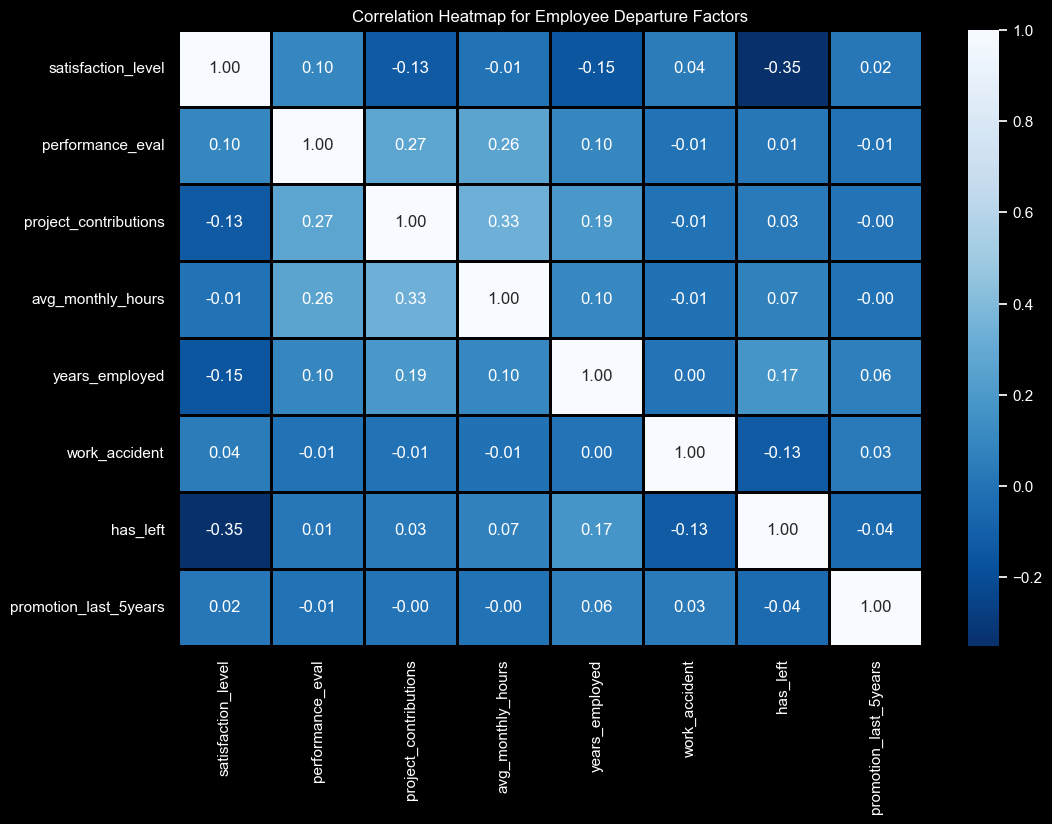

In [70]:
# Correlation Heatmap

# Dropping 'department' and 'salary' columns for correlation analysis as they are non-numeric
df2 = df1.drop(['department', 'salary'], axis=1)

# Calculating correlations
corr = df2.corr()

# Viz
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap="Blues_r", fmt=".2f", linewidths=1, linecolor='black')
plt.title('Correlation Heatmap for Employee Departure Factors')
plt.show()


### Correlation Heatmap Insights
- Satisfaction Level & Leaving: Negatively correlated (-0.35), lower satisfaction higher likelihood of leaving.
- Years Employed & Leaving: Positive correlation (0.17), longer tenure slightly higher departure rate. 
- Work Accident & Leaving: Negatively correlated (-0.13), employees with work accidents less likely to leave
- Promotion & Leaving: Negative correlation (-0.04), promotions significantly reduce chances of leaving.

Job satisfaction, tenure, safety, and growth opportunities are pivotal in employee retention.


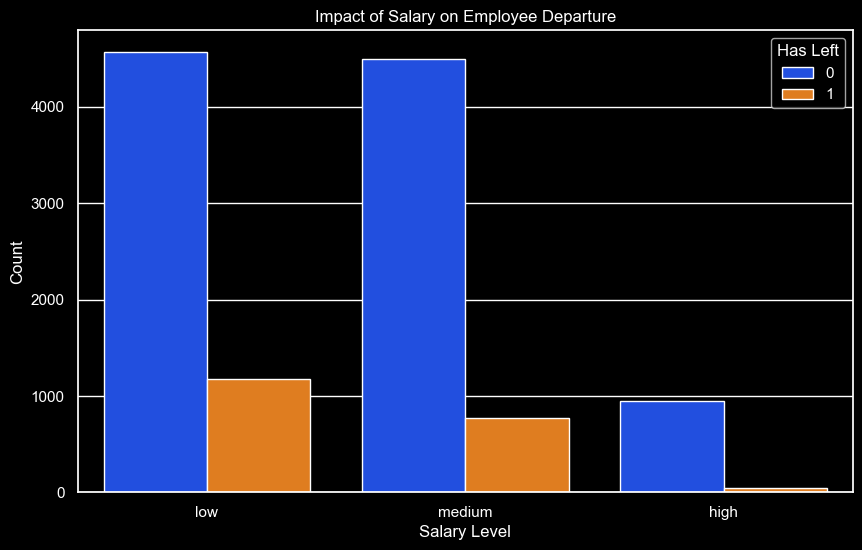

In [71]:
# Impact of Salary on Employee Departure

# Ordering the salary levels for better viz
salary_order = ['low', 'medium', 'high']  

# Viz
plt.figure(figsize=(10, 6))
sns.countplot(x='salary', hue='has_left', data=df1, order=salary_order, palette='bright')
plt.title('Impact of Salary on Employee Departure')
plt.xlabel('Salary Level')
plt.ylabel('Count')
plt.legend(title='Has Left', loc='upper right')
plt.show()

### Salary Impact
- Higher Leave Rate for Lower Salaries: Employees with lower salaries have a significantly higher tendency to leave. 
- Reduced Departures with Higher Salary: As salary increases, the likelihood of leaving decreases notably.

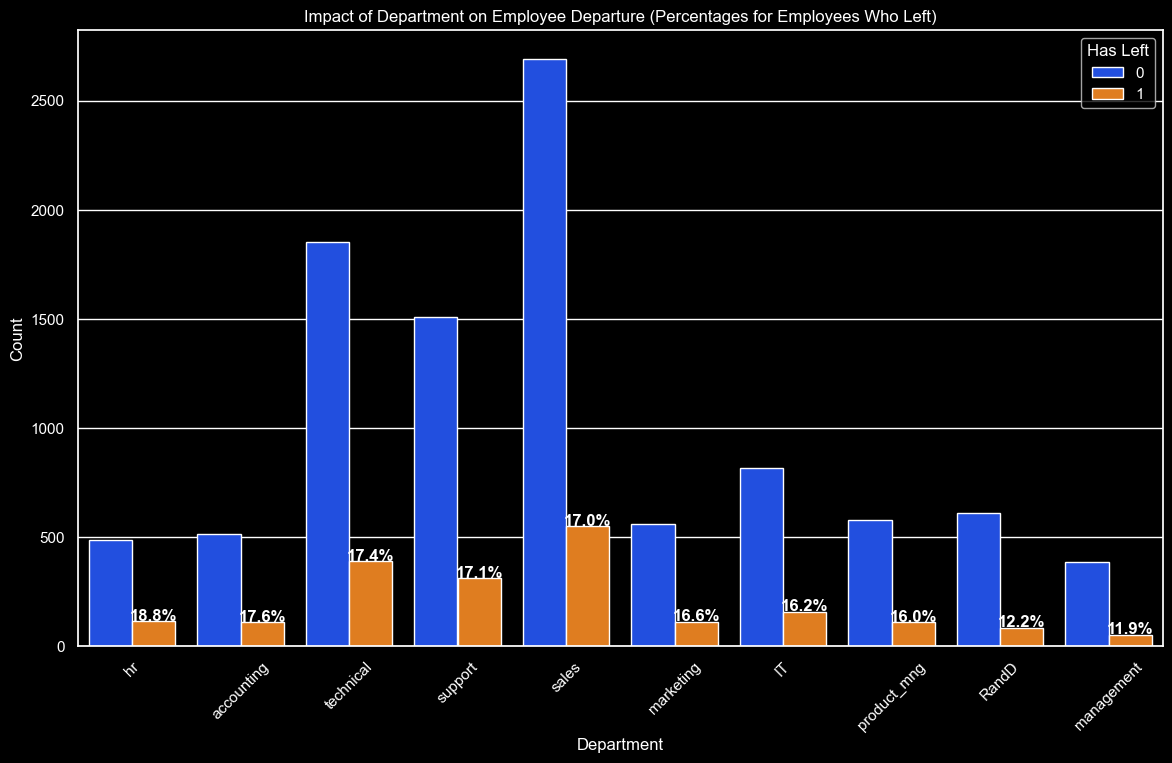

In [72]:
# Impact of Department on Employee Departure (Percentages for Employees Who Left)

# Percentage of employees that left by department
dept_leave_counts = df1.groupby(['department', 'has_left']).size().unstack(fill_value=0)
dept_leave_percentages = dept_leave_counts[1] / (dept_leave_counts[0] + dept_leave_counts[1]) * 100
dept_leave_percentages = dept_leave_percentages.sort_values(ascending=False)  # Sorting by percentage

# Viz
plt.figure(figsize=(14, 8))
chart = sns.countplot(x='department', hue='has_left', data=df1, order=dept_leave_percentages.index, palette='bright')
plt.title('Impact of Department on Employee Departure (Percentages for Employees Who Left)')
plt.xticks(rotation=45)
plt.xlabel('Department')
plt.ylabel('Count')
plt.legend(title='Has Left', loc='upper right')

# Calculating total counts for departments
total_counts = df1['department'].value_counts()

# Annotating percentages orange only
num_departments = len(dept_leave_percentages.index)
for i, p in enumerate(chart.patches):
    if i >= num_departments:  
        department = dept_leave_percentages.index[i - num_departments]
        height = p.get_height()
        total = total_counts[department]
        if height > 0:
            percentage = 100 * height / total
            chart.text(p.get_x() + p.get_width() / 2., height + 3, f'{percentage:.1f}%', ha="center", color='white', fontsize=12, fontweight='bold')

plt.show()


### Department Impact
- Department Influence: The impact of department on leaving seems insignificant, but certain departments experience slightly higher turnover rates (HR, Accounting) while others are lower (RandD, management). 
- 6.9% difference from the highest to lowest department rate. 

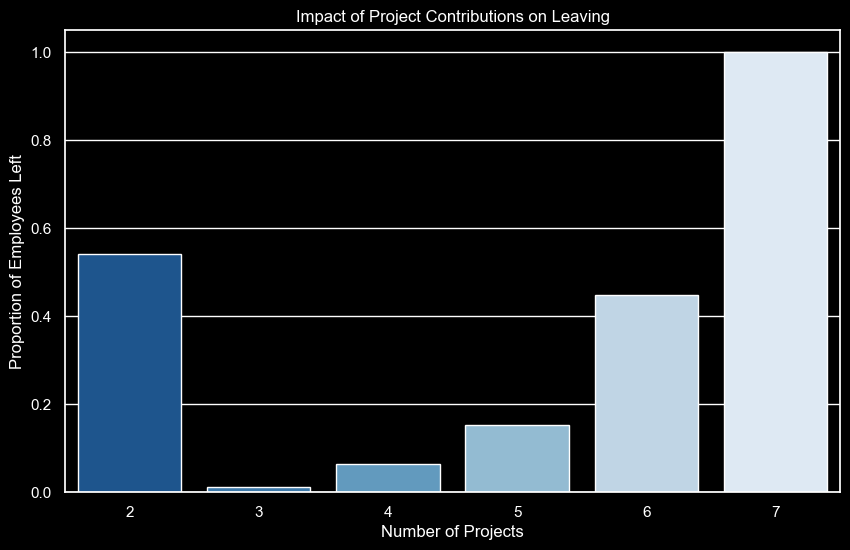

In [73]:
# Impact of Project Contributions on Leaving

# Project levels
project_order = df1['project_contributions'].value_counts().sort_index().index

# Viz
plt.figure(figsize=(10, 6))
sns.barplot(x='project_contributions', y='has_left', data=df1, errorbar=None, palette='Blues_r', order=project_order)
plt.title('Impact of Project Contributions on Leaving')
plt.xlabel('Number of Projects')
plt.ylabel('Proportion of Employees Left')
plt.show()




### Impact of Project Contributions
- Under and over utilization can be detrimental. 3-5 projects seems to be the sweet spot. 
- ALL employees with 7 projects left the company

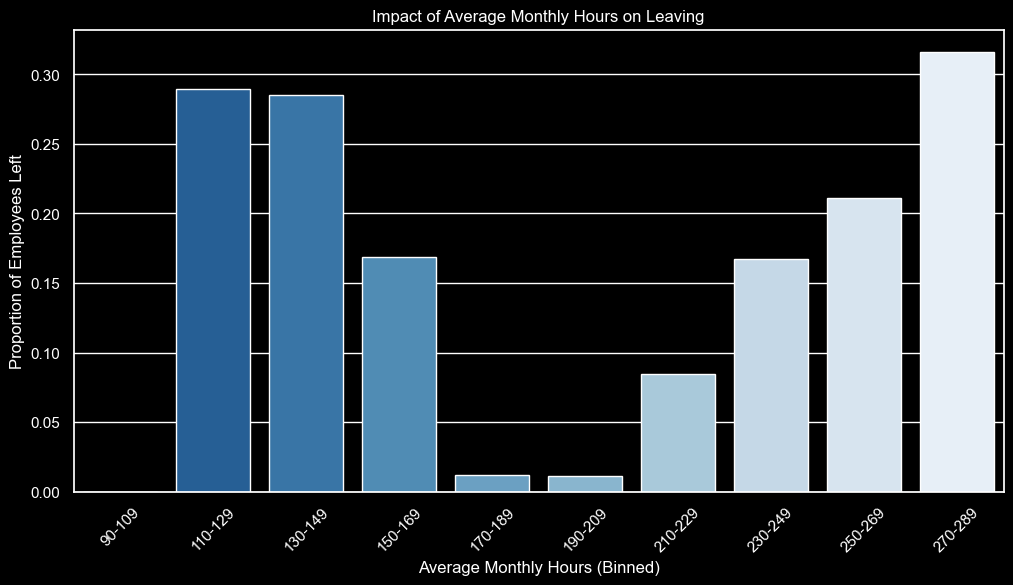

In [74]:
# Impact of Average Monthly Hours on Leaving

# Creating a copy of df1 to avoid error
df1_copy = df1.copy()

# Binning average monthly hours
df1_copy['hours_bin'] = pd.cut(df1_copy['avg_monthly_hours'], bins=range(90, 310, 20), labels=[f"{i}-{i+19}" for i in range(90, 290, 20)])

# Capturing sorted order of hours bins for the viz
sorted_hours_bins = df1_copy.groupby('hours_bin')['has_left'].mean().sort_index().index

plt.figure(figsize=(12, 6))
sns.barplot(x='hours_bin', y='has_left', data=df1_copy, errorbar=None, palette='Blues_r', order=sorted_hours_bins)
plt.title('Impact of Average Monthly Hours on Leaving')
plt.xlabel('Average Monthly Hours (Binned)')
plt.ylabel('Proportion of Employees Left')
plt.xticks(rotation=45)
plt.show()


### Impact of Average Monthly Hours on Leaving
- Under and over utilization showing up again. Significant population looks to be overworked. 
    - Assume average working hours 40 hours x 52 weeks / 12 = 173.3 monthly average, not even accounting for vacations.

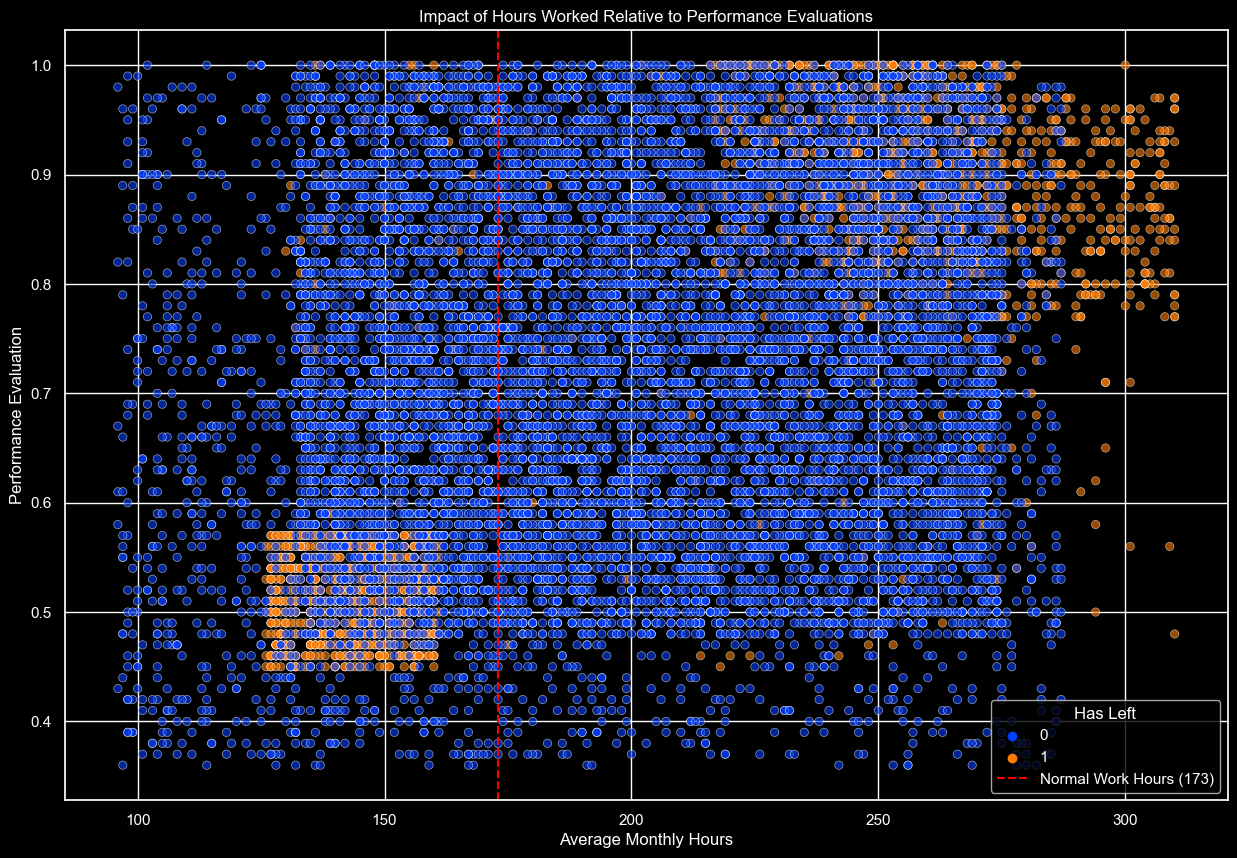

In [75]:
# Impact of Hours Worked Relative to Performance Evaluations

# Viz
sns.set(style="darkgrid")
plt.style.use("dark_background")
plt.figure(figsize=(15, 10))
sns.scatterplot(x='avg_monthly_hours', y='performance_eval', data=df1, hue='has_left', palette='bright', alpha=0.6)
plt.axvline(173, color='red', linestyle='--', label='Normal Work Hours (173)')
plt.title('Impact of Hours Worked Relative to Performance Evaluations')
plt.xlabel('Average Monthly Hours')
plt.ylabel('Performance Evaluation')
plt.legend(title='Has Left')
plt.show()



### Impact of Hours Worked Relative to Performance Evaluations
- Setting normal work hours at 173 per month, these folks are definitely overworked. 
- 2 significant groups of folks who left:
    - Overworked employees with above average scores
    - Under worked employees with below average scores
        - This could be indicative of folks let go, rather than leaving on their own 

## Summarized Insights:
- Job Satisfaction & Leaving:
    - Negative correlation (-0.35): Lower satisfaction increases likelihood of leaving.
    
- Salary Impact on Departures:
    - Lower salaries associated with significantly higher leaving rates.
    - Higher salaries notably decrease leaving likelihood.

- Impact of Project Contributions:
    - Optimal project load: 3-5 projects; all employees with 7 projects left.

- Department Influence on Turnover:
    - Insignificant overall impact, but variations across departments observed.
    - Notable turnover differences among departments (6.9% gap).

- Tenure & Leaving:
    - Positive correlation (0.17): Longer tenure slightly increases departure rates.

- Hours Worked & Performance Evaluation:
    - Overworked employees with above-average scores left.
    - Underworked employees with below-average scores also left, suggestive of potential involuntary departures.

- Work Accidents & Leaving:
    - Negative correlation (-0.13): Employees with work accidents less likely to leave.

- Promotion & Leaving:
    - Negative correlation (-0.04): Promotions decrease leaving chances.

## Model Construction:

### Overview: 

The next section involves building models in order to predict wether an employee may or not leave the company, with the ultimate goal of preventing retaining high value employees. The questions here are what type of prediction do we want to make, and what types of models are most appropriate for the task?

### Prediction type:

- We want to predict if an employee may or not leave the company
- This can be defined as a <ins>categorical outcome variable</ins>
- For this we'll be focussing on the "has_left" column. This column has one of two variables:
    - 1 - indicating that the employee left the company
    - 0 - indicating that they are still employed.
    - With two possible outcomes, this is considered <ins>binary classification</ins> 

### Appropriate models:

I've determined that **Binomial Logistic Regression** and **XGBoost** will be the most appropriate. 
- **Binomial Logistic Regression** is favored for binary classification due to its interpretability; it provides coefficients that directly indicate the impact of predictors on the outcome variable, making it easy to understand the relationship between predictors and the likelihood of the outcome.
- **XGBoost** stands out for binary classification tasks because of its flexibility in handling complex non-linear relationships between predictors and the outcome variable. It offers high performance in terms of accuracy and efficiency, making it a popular choice in various competitions and real-world applications.



## Binomial Logistic Regression

#### Check out the below code block on my process for developing the model

In [80]:
# Binomial Logistic Regression Model

# Setting a new df for this model as it needs further manipulation for best accuracy
df1_BLR = df1.copy()

# `salary` can be represented as numeric category
salary_mapping = {'low': 0, 'medium': 1, 'high': 2}
df1_BLR['salary'] = df1_BLR['salary'].map(salary_mapping)

# Dummying `department` 
df1_BLR = pd.get_dummies(df1_BLR, drop_first=False)

# Calculating and removing outliers from 'years_employed' as this was the only column with significant outliers
q1 = df1_BLR['years_employed'].quantile(0.25)
q3 = df1_BLR['years_employed'].quantile(0.75)
iqr = q3 - q1
lower_limit = q1 - 1.5 * iqr
upper_limit = q3 + 1.5 * iqr

blr = df1_BLR[(df1_BLR['years_employed'] >= lower_limit) & (df1_BLR['years_employed'] <= upper_limit)]

'''
# Test to confirm -824 outliers confirmed by original outlier count
df1.info()
blr.info()
'''

# Isolating variables
X = blr.drop('has_left', axis=1) # Features, A.K.A. what we compare to the target to see how it's affected
y = blr['has_left'] # Target, A.K.A. what we want to predict 

# Splitting df into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Creating the model and fitting to training set, and initiating on test
log_clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)
y_pred = log_clf.predict(X_test)

#### Visualization and reporting.  

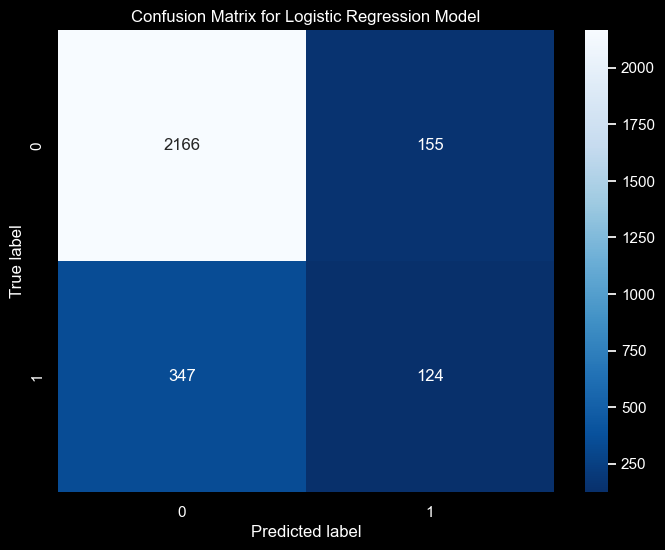

Class_Balance
has_left
0    0.831304
1    0.168696
Name: proportion, dtype: float64
Classification Report:
                    precision    recall  f1-score      support
Predicted to Stay    0.861918  0.933218  0.896152  2321.000000
Predicted to Leave   0.444444  0.263270  0.330667   471.000000
accuracy             0.820201  0.820201  0.820201     0.820201
macro avg            0.653181  0.598244  0.613409  2792.000000
weighted avg         0.791492  0.820201  0.800757  2792.000000


In [84]:
#Reporting
# Creating a confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.set(style="darkgrid")
plt.style.use("dark_background")
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues_r')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()

# Class balance and classification Report
class_balance = y_test.value_counts(normalize=True)

class_labels = {0: 'Predicted to Stay', 1: 'Predicted to Leave'}
class_report_relabeled = classification_report(y_test, y_pred, target_names=class_labels.values(), output_dict=True)

# Refining for readability
class_report_relabeled_df = pd.DataFrame(class_report_relabeled).transpose()
accuracy_relabeled = (conf_mat[0, 0] + conf_mat[1, 1]) / conf_mat.sum()
class_report_relabeled_df.loc['accuracy', 'precision'] = accuracy_relabeled

print("Class_Balance")
print(class_balance)
print("Classification Report:")
print(class_report_relabeled_df)

## Making Sense of The Model, and Next Steps. 

#### Model breakdown:

The above visualization is what's known as a confusion matrix. It's tool used to assess the performance of classification models. The matrix itself is divided into four parts:

- **True Negatives (TN) (upper-left)**: These are the cases in which the model correctly predicts the negative class. 
    - Here, the model accurately predicted the employees who have not left the company.

- **False Positives (FP) (upper-right)**: Also known as Type I error, these are the cases in which the model incorrectly predicts the positive class. 
    - Here, the model predicted an employee has left the company when, in reality, they have not.

- **False Negatives (FN) (bottom-left)**: Also known as Type II error, these are the cases in which the model incorrectly predicts the negative class. 
    - Here, the model predicted an employee has not left the company when, in fact, they have.

- **True Positives (TP) (bottom-right)**: These are the cases in which the model correctly predicts the positive class. 
    - Here, it means the model accurately predicted the employees who have left the company.

- In theory, perfect model would retrieve all true negatives and true positives with no results in the remaining two quadrants 

## Summary Results and Conclusion So Far:

The class balance shows roughly an 83%-17% split. This means the data isn't perfectly balanced, but not so much to where we'd need to modify the split. 

The classification report above shows that the model produced the following:
 - Precision of 79%
 - Recall of 82%
 - F1-score of 80%
 - Accuracy of 82%. 
 
Initially this may look like an adequate model in order to make some decently informed predictions, but highlighting the significance of the ability to predict employees leaving specifically, the scores are actually much lower. Further modeling is needed in order to confirm results. 

## Next Up: 

If you've made it this far, thanks for reading! I'll soon be posting further analysis utilizing some Machine Learning techniques in the coming weeks featuring:
- Tree-based ML models
    - Decision Tree 
    - Random Forest
- Feature Engineering 
- Finalized Next Steps

Until then, I hope you found this interesting and insightful!



-Ryan 